In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sys import getsizeof as size

In [2]:
DF = pd.read_csv("yle_ehdokkaat.csv",skiprows=0)

In [3]:
# EXPERIMENTAL STUFF
def clean(x):
    if type(x) != float and not x.isdigit():
        return 0
    elif x == float('nan'):
        return 0
    elif math.isnan(float(x)):
        return 0
    else:
        return int(x)
# Make into element-wise function
vclean = np.vectorize(clean)


def filter_blanks(df_region):
    temp_mat = vclean(df_region.to_numpy()[:,3:])
    removables_by_index = []
    for i,j in enumerate(temp_mat):
        if np.sum(j) == 0: removables_by_index.append(i)
            
    removables = [df_region.index[idx] for idx in removables_by_index]
    # print("Removing {} empty rows from {}".format(len(removables),df_region.iloc[0][0]))
    return df_region.drop(removables)

def to_dict_mat(df_clean_region):
    # print(df_clean_region.shape)
    
    temp_mat = vclean(df_clean_region.to_numpy()[:,3:])
    
    # print(vclean(df_clean_region.to_numpy()[:,0]))
    names= list(df_clean_region.index) # Has same order as m
    a,b,c = zip(*df_clean_region.to_numpy()[:,:3])
    d = {j:(a[i],b[i],c[i]) for i,j in enumerate(names)} # {int: (str,str,int)} // {id: (region, party, elected)}
    # print(temp_mat.shape)
    return names, d, temp_mat

def general_dict(regions):
    d = {}
    x = np.sum(np.asarray([x.shape[0] for x in regions]))
    ids = []
    mats = []

    for r in regions:
        cand_ids,D,M = to_dict_mat(r)
        mats.append(M)
        ids.append(cand_ids)
        for a,b in D.items():
            d[a] = b 
    
    return ids,d,np.concatenate(mats)

def clean_data(df):
    l = []
    regions = np.unique(df.vaalipiiri)
    for piiri in np.unique(df.vaalipiiri):
        # print(piiri)
        # 1) Filter out completely Nan rows
        piiri_df = df[df.vaalipiiri == piiri].dropna(axis=1,how='all')

        # 2) Get columns contain only text answers
        removable_cols = list(piiri_df.columns[range(32,82)]) + [col for col in piiri_df.columns if col[-1] == "1"]
        
        # 3) Remove semi-manually 4 questions that were removed afterwards
        removed_questions = ["Energiajuomien myyminen alle", "Nuuskan, purutupakan ja", "On olemassa pyhiä tai muuten", "On oikein nähdä vaivaa sen eteen"]
        
        for que in removed_questions:
            for col in piiri_df.columns:
                if que in col: removable_cols.append(col) 
        
        # 4) Drop those columns and add dataframe to `l` 
        dropped = piiri_df.drop(removable_cols,axis="columns")
        l.append(filter_blanks(dropped))
    
    ids,d,mats = general_dict(l)
    flattened_ids = np.asarray([x for z in ids for x in z])
    m = np.column_stack((flattened_ids,mats))
    
    return ids,d, m,regions

def Msub(ids,m,reg_idx):
    start = 0
    for i in range(reg_idx): start+= len(ids[i])
    end = start+len(ids[reg_idx])
    return m[start:end]

def get_ids(m):
    return m[:,0].astype(int)

def e(D,cand):
    return 1 if D[cand][2] in [1,2] else 0
    

In [4]:
def distance_check(i,j,A):
    return A[i,j]

vdc = np.vectorize(distance_check) # Vectorized element distance look-up for FAST SPEEDS
vdc.excluded.add(2)

def distance(i,j,M, A,norm,skip_policy):
    """Return the scalar distance between rows `i` and `j` (not equal) of `M`, using mapping `A`
    for the row elements, `norm` for the norm and a pre-defined 'skip_policy'. Pairs of elements
    of M[i] and M[j] are mapped to a specific distance in A[i,j]. A pre-determined A and
    skip_policy lets one create arbitrary distance functions.
    """

    assert M[i].shape == M[j].shape, "M[i].shape is not M[j].shape"
    assert skip_policy in ["user_first","soft_skip","hard_skip"], "Skip policy not defined"
    
    # If "user_first", assume i = user, j = candidate
    
    # skip_filter determines which answer pairs ARE NOT SKIPPED (needed for normalization)
    
    if skip_policy == "user_first":
        skip_filter = M[i] != 0 # Remember that i = user
    elif skip_policy == "soft_skip":
        skip_filter = np.logical_or(M[i] != 0, M[j] != 0)
    elif skip_policy == "hard_skip":
        skip_filter = np.logical_and(M[i] != 0, M[j] != 0)
    
    
    # Normalizing
    v = vdc(M[i],M[j],A)[skip_filter]
    z = ((np.sum(v**norm))**(1/norm) ) /(v.shape[0])
    if np.isnan(z): print(M[i],M[j])
    return z
# REGARDING DISTANCE METRIC
# Three skip policies
# "user_first": - If candidate skips but user doesn't --> Max dist
#               - If user skips --> Skip question

# "soft_skip" : - If either skips --> Skip question

# "hard_skip" : - If one skips --> Max dist
#               - If both skip --> Skip question


In [5]:
# This part is referred to in thesis.


# Traditional 5-point Likert scale
A_5 = np.asarray( # 5-point Likert
[[999,   1,   1,   1,   1,  1], 
 [  1,   0, .25,  .5, .75,  1],
 [  1, .25,   0, .25,  .5,.75],
 [  1,  .5, .25,   0, .25, .5],
 [  1, .75,  .5, .25,   0,.25],
 [  1,   1, .75,  .5, .25,  0],
])

# Mapping from 5-point to a 3-point Likert scale
A_3 = np.asarray(
[[999,   1,   1,   1,   1,  1],
 [  1,   0,   0,  .5,   1,  1],
 [  1,   0,   0,  .5,   1,  1],
 [  1,  .5,  .5,   0,  .5, .5],
 [  1,   1,   1,  .5,   0,  0],
 [  1,   1,   1,  .5,   0,  0],
])


# Binary distance mapping
# (1,2) -> 0
# (2,3) -> 1
# (1,5) -> 1
# (2,4) -> 1

A_2 = np.asarray( 
[[999,   1,   1,   1,   1,  1],
 [  1,   0,   0,   1,   1,  1],
 [  1,   0,   0,   1,   1,  1],
 [  1,   1,   1,   0,   1,  1],
 [  1,   1,   1,   1,   0,  0],
 [  1,   1,   1,   1,   0,  0],
])

A_dir = np.asarray(
[[999,   1,    1,   1,   1,  1],
 [  1,   0,  .25,  .5, .75,  1],
 [  1, .25, .375,  .5,.625,.75],
 [  1,  .5,   .5,  .5,  .5, .5],
 [  1, .75, .625,  .5,.375,.25],
 [  1,   1,  .75,  .5, .25,  0],
])

A_hyb = np.asarray( 
[[999,   1,    1,   1,    1,  1],
 [  1,   0,  .25,  .5,  .75,  1],
 [  1, .25,.1875,.375,.5625,.75],
 [  1,  .5, .375, .25, .375, .5],
 [  1, .75,.5625,.375,.1875,.25],
 [  1,   1,  .75,  .5,  .25,  0],
])

As = [A_5, A_3, A_2, A_dir, A_hyb]

In [6]:
IDS,D,M,REGIONS = clean_data(DF)

RIDX = list(range(len(IDS)))
M_regs = [Msub(IDS,M,i) for i in RIDX]
N_CANDS = M.shape[0] # 2263
RWEIGHTS = np.asarray([len(x) for x in IDS]) / np.sum(np.asarray([len(x) for x in IDS]))
ELECTED_RATIO = sum([1 for i,c in D.items() if c[2] == 1]) / len(D.items())
PARTIES = np.unique(DF.puolue)
print(REGIONS)

['Ahvenanmaan maakunnan vaalipiiri' 'Helsingin vaalipiiri'
 'Hämeen vaalipiiri' 'Kaakkois-Suomen vaalipiiri'
 'Keski-Suomen vaalipiiri' 'Lapin vaalipiiri' 'Oulun vaalipiiri'
 'Pirkanmaan vaalipiiri' 'Satakunnan vaalipiiri'
 'Savo-Karjalan vaalipiiri' 'Uudenmaan vaalipiiri' 'Vaasan vaalipiiri'
 'Varsinais-Suomen vaalipiiri']


# Does answering a single question unproportionally lead to suggesting a candidate or party?

# Candidate bias

In [8]:
"""

def candidate_fixed_dists(M_regs,A,norm):

    
    fixed_answers = []
    for j in range(30):
        for u in range(1,6):
            t = [3]*30
            t[j] = u
            fixed_answers.append(t)



    fixed_dists = []

    for k,M_reg in enumerate(M_regs):
        print(f"Calculating fixed distances for {REGIONS[k]}")
        for i,fixed in enumerate(fixed_answers):
            M_answers = np.vstack((np.asarray(fixed),M_reg[:,1:]))

            dists = [distance(0,j,M_answers,A,norm,"user_first") for j in range(M_reg.shape[0])]
            fixed_dists.append((i,dists))
        print(size(fixed_dists))
    return fixed_dists"""




def candidate_fixed_dists(M_regs,A,norm):
    fixed_answers = []
    for j in range(30):
        for u in range(1,6):
            t = [3]*30
            t[j] = u
            fixed_answers.append(t)
    
    df_dists = pd.DataFrame(columns = M[:,0],index=range(150))
    for k,M_reg in enumerate(M_regs):
        print(f"Calculating fixed distances for {REGIONS[k]}")
        for i,fixed in enumerate(fixed_answers):
            M_answers = np.vstack((np.asarray(fixed),M_reg[:,1:]))
            for z,d in enumerate([distance(0,j+1,M_answers,A,norm,"user_first") for j in range(M_reg.shape[0])]):
                cand_id = M_reg[z][0]
                df_dists.loc[i][cand_id] = d
    return df_dists
fds = candidate_fixed_dists(M_regs,A_5,2)
# print(fds)


Calculating fixed distances for Ahvenanmaan maakunnan vaalipiiri
Calculating fixed distances for Helsingin vaalipiiri
Calculating fixed distances for Hämeen vaalipiiri
Calculating fixed distances for Kaakkois-Suomen vaalipiiri
Calculating fixed distances for Keski-Suomen vaalipiiri
Calculating fixed distances for Lapin vaalipiiri
Calculating fixed distances for Oulun vaalipiiri
Calculating fixed distances for Pirkanmaan vaalipiiri
Calculating fixed distances for Satakunnan vaalipiiri
Calculating fixed distances for Savo-Karjalan vaalipiiri
Calculating fixed distances for Uudenmaan vaalipiiri
Calculating fixed distances for Vaasan vaalipiiri
Calculating fixed distances for Varsinais-Suomen vaalipiiri
          1070       1071       1072       1073       1074      488   \
0    0.0812233  0.0745356   0.073598  0.0745356      0.075  0.105738   
1    0.0790569      0.075  0.0731247  0.0721688   0.071686  0.106066   
2    0.0777282  0.0763763   0.073598  0.0707107  0.0692219  0.107044   
3  

1.7988228185971415

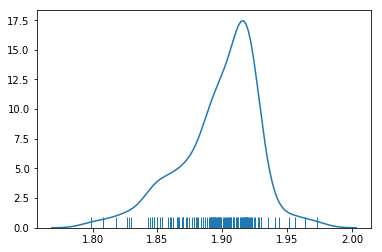

In [25]:
arr_fds = fds.to_numpy()

#sns.distplot(arr_fds[0],hist=False,rug=True)



# row_prob = arr_fds[0]/arr_fds[0].sum(axis=0)

maxs_over_means = np.asarray([row.max()/row.mean() for i,row in enumerate(arr_fds)])
mins_over_means = np.asarray([row.min()/row.mean() for i,row in enumerate(arr_fds)])


sns.distplot(maxs_over_means,hist=False,rug=True)

maxs_over_means.max()
maxs_over_means.min()